In [1]:
%load_ext autoreload
%autoreload 2

import qubx

%qubxd
import pandas as pd

from qubx.data.readers import (
    CsvStorageDataReader,
    QuestDBConnector,
    AsPandasFrame,
    AsOhlcvSeries,
    AsQuotes,
    RestoreTicksFromOHLC,
    AsTimestampedRecords,
    CME_FUTURES_DAILY_SESSION,
    STOCK_DAILY_SESSION,
)
from qubx.data.helpers import loader
from qubx.core.series import OrderBook
from qubx.core.basics import Instrument
from qubx.core.lookups import lookup
import numpy as np
from numba import njit

from hftbacktest import BacktestAsset, HashMapMarketDepthBacktest, ROIVectorMarketDepthBacktest
from hftbacktest.types import *
from typing import TypeAlias
from qubx.data.readers import AsOrderBook
from qubx.data.hft import HftDataReader

from qubx.core.basics import Signal, TimestampedDict
from qubx.core.interfaces import IStrategy, IStrategyContext, TriggerEvent, MarketEvent
from qubx.data.readers import MultiTypeReader
from qubx.pandaz.utils import *

from qubx.backtester.simulator import simulate
from qubx import logger


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2025, ver. 0.6.1
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


In [2]:
hft_reader = HftDataReader(path="/hft-data")

In [3]:
iterator = hft_reader.read(
    data_id="BINANCE.UM:BTCUSDT",
    start="2025-01-01",
    stop="2025-01-02",
    data_type="orderbook",
    transform=AsOrderBook()
)

In [23]:
chunk = next(iterator)

In [25]:
chunk[-1]

[2025-01-01T04:10:02.051000000] 93699.90000000001 (1.499) | 93700.0 (3.287)

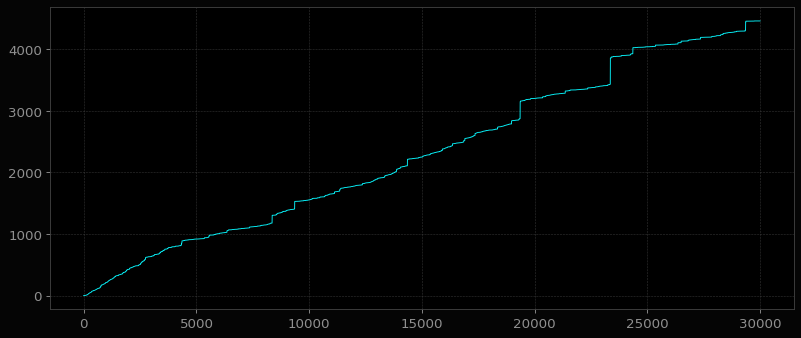

In [15]:
pd.Series(chunk[0].bids).cumsum().plot();

In [2]:
class TestB(IStrategy):

    def on_init(self, ctx: IStrategyContext):
        self.orderbooks = []

    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent) -> list[Signal] | Signal | None:
        self.orderbooks.append(data.data)

In [12]:
r = simulate(
   strategies={"Test": (stg:=TestB())},
   data={"orderbook": HftDataReader(path="/hft-data", max_ticks=100)},
   capital=1000,
   instruments=["BINANCE.UM:BTCUSDT"],
   commissions="vip0_usdt",
   start="2025-01-01",
   stop="2025-01-02",
   debug="DEBUG"
)

2025-01-01 00:00:00.000 [🐞] [simulator] :: Preparing simulated trading on BINANCE.UM for 1000 USDT...
2025-01-01 00:00:00.000 [ℹ️] SimulatedDataProvider.binance.um is initialized


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2025-01-01 00:00:00.000 [🐞] [simulator] :: Setting up default base subscription: orderbook
2025-01-01 00:00:00.000 [🐞] [simulator] :: Strategy didn't set warmup period for orderbook so default 1Min will be used
2025-01-01 00:00:00.000 [🐞] [simulator] :: Subscribing to: orderbook
2025-01-01 00:00:00.000 [ℹ️] SimulatedDataProvider ::: Simulation started at 2025-01-01 00:00:00 :::
2025-01-01 00:00:00.000 [🐞]   [IteratedDataStreamsSlicer] :: Preloading initial data for orderbook 2025-01-01 00:00:00 : 2025-01-02 00:00:00 ...
2025-01-01 00:00:01.051 [🐞] [ProcessingManager] :: Invoking TestB on_fit
2025-01-01 00:00:01.051 [🐞] [ProcessingManager] :: TestB is fitted


IndexError: list index out of range

In [13]:
stg.orderbooks[0]

[2025-01-01T00:00:02.051000000] 93548.70000000001 (7.429) | 93548.8 (1.335)

In [14]:
stg.orderbooks[-1]

[2025-01-02T23:59:59.051000000] 96967.5 (8.705) | 96967.6 (4.503)

In [15]:
len(stg.orderbooks)

172764

In [10]:
from qubx.utils.misc import Stopwatch

In [16]:
Stopwatch.latency_report()

,scope,latency,count,total_time (min)
0,loggers.notify,0.0000,345529,0.0232
1,CachedMarketDataHolder.update_by_quote,0.0000,172765,0.0117
2,StrategyContext.handler,0.0000,172765,0.0620
3,StrategyContext.on_fit.__invoke_on_fit,0.0007,1,0.0000
4,StrategyContext.on_event,0.0000,172764,0.0058
